In [96]:
!pip install -q git+https://github.com/huggingface/transformers.git

ERROR: Operation cancelled by user


## Load image

Let's load our favorite cats image on which we'll perform inference.

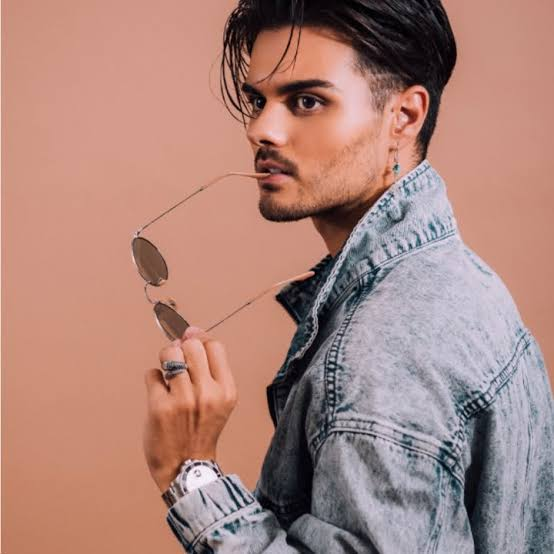

In [97]:
from PIL import Image
import requests

image_path = "input.jpeg"
image = Image.open(image_path)
image

## Prepare image and text prompts

We can prepare the image along with a text prompt for the model.

In [98]:
from transformers import GroundingDinoProcessor

processor = GroundingDinoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

As the Grounding DINO model was trained with a "." after each text, we'll do the same here.

In [99]:
text = "watch"

In [100]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

inputs = processor(images=image, text=preprocess_caption(text), return_tensors="pt")

## Load model

Let's load the model from the 🤗 hub. Do note that the authors [released](https://huggingface.co/models?other=grounding-dino) 2 checkpoints, a "tiny" and a "base" version.

In [101]:
from transformers import GroundingDinoForObjectDetection

model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base")

## Forward pass

Let's perform a forward pass - we'll use the `torch.no_grad()` context manager as we don't need gradients to be computed at inference time, which saves us memory.

In [102]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Visualize predictions

Let's visualize the results!

In [103]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [104]:
# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_grounded_object_detection(outputs,
                                                                input_ids=inputs.input_ids,
                                                                target_sizes=[(height, width)],
                                                                box_threshold=0.3,
                                                                text_threshold=0.1)
results = postprocessed_outputs[0]

<ipython-input-104-b2c20147deb2>:3: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  postprocessed_outputs = processor.post_process_grounded_object_detection(outputs,


/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


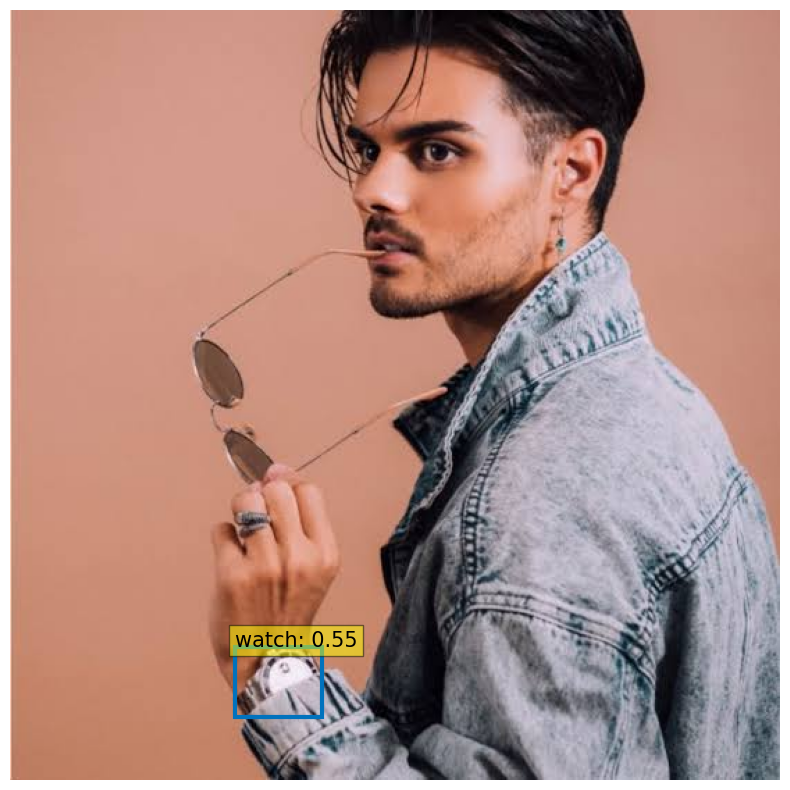

In [105]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [106]:
print(results)

{'scores': tensor([0.5524]), 'boxes': tensor([[161.3548, 457.6638, 223.9829, 508.0650]]), 'text_labels': ['watch'], 'labels': ['watch']}


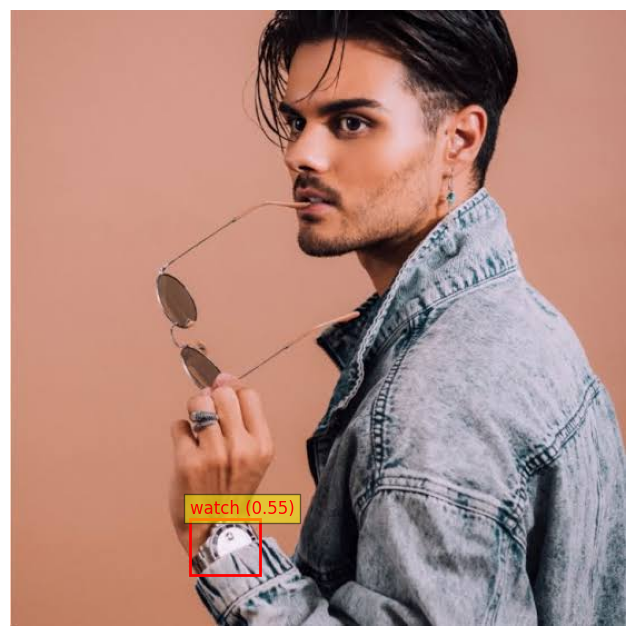

In [107]:
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw

# (Se asume que ya tienes tu imagen cargada en la variable "image",
#  y que has ejecutado los pasos previos para obtener "results".)
# results -> diccionario con 'scores', 'labels', 'boxes'

# Asegurarte de que existe la carpeta de salida
os.makedirs("outputs", exist_ok=True)

def plot_and_save_detections(image, results):
    """
    Dibuja las bounding boxes en la imagen original con Matplotlib
    y guarda la visualización completa en output/detections.png
    Además, para cada objeto detectado, genera y guarda una versión
    recortada con fondo transparente (basada en la caja).
    """
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    # Recorremos todas las detecciones
    for i, (score, label, box) in enumerate(zip(results['scores'],
                                                results['labels'],
                                                results['boxes'])):
        # box es [x0, y0, x1, y1]
        x0, y0, x1, y1 = box.tolist()

        # Dibuja el rectángulo sobre la imagen
        width = x1 - x0
        height = y1 - y0
        rect = patches.Rectangle((x0, y0), width, height,
                                 linewidth=2,
                                 edgecolor='red',
                                 facecolor='none')
        ax.add_patch(rect)

        # Texto: etiqueta y score
        caption = f"{label} ({score:.2f})"
        ax.text(x0, y0 - 5, caption, color='red', fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))

        # -------------------------------------------------------------
        # 1) Recortar el objeto de la imagen original
        # -------------------------------------------------------------
        # Convertimos a coordenadas enteras por si viniera en float
        crop_box = (int(x0), int(y0), int(x1), int(y1))
        cropped_object = image.crop(crop_box)

        # -------------------------------------------------------------
        # 2) Crear un fondo transparente y pegar el recorte allí
        # -------------------------------------------------------------
        # - Para cada objeto, creamos un lienzo del mismo tamaño que "cropped_object",
        #   en modo RGBA (para soportar transparencia).
        # - Pegamos el recorte en ese lienzo.
        # - Eso deja todo lo demás (fuera de la caja) transparente.
        w, h = cropped_object.size
        transparent_bg = Image.new("RGBA", (w, h), (0, 0, 0, 0))
        transparent_bg.paste(cropped_object, (0, 0))

        # Guardar el objeto enmascarado
        object_filename = f"output/object_{i}.png"
        transparent_bg.save(object_filename)

    # Guardamos la figura con todos los bounding boxes dibujados
    output_detections_filename = "output/detections.png"
    plt.axis('off')
    plt.savefig(output_detections_filename, bbox_inches='tight')
    plt.show()

# --------------------
# EJEMPLO DE USO
# --------------------

# Después de haber obtenido `results` usando GroundingDINO, llama a la función:
plot_and_save_detections(image, results)

In [108]:
%pip install transformers
%pip install torch
%pip install torchvision
%pip install matplotlib

In [109]:
%pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-05kvhw48
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-05kvhw48
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [110]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Segment-Anything
from segment_anything import SamPredictor, sam_model_registry

# GroundingDINO
from transformers import AutoProcessor, GroundingDinoForObjectDetection

In [111]:
# -------------------------
#   PARÁMETROS PRINCIPALES
# -------------------------
GROUNDING_DINO_MODEL = "IDEA-Research/grounding-dino-base"
SAM_CHECKPOINT_PATH  = "sam_vit_b_01ec64.pth"  # Ajusta a la ruta local del checkpoint
SAM_MODEL_TYPE       = "vit_b"                # vit_h, vit_l, vit_b, etc. según corresponda
DEVICE              = "cuda" if torch.cuda.is_available() else "cpu"

# Asegúrate de que existe la carpeta de salida
os.makedirs("outputs", exist_ok=True)

In [112]:
# -------------------------
#   1) CARGAR LOS MODELOS
# -------------------------
processor = AutoProcessor.from_pretrained(GROUNDING_DINO_MODEL)
model_dino = GroundingDinoForObjectDetection.from_pretrained(GROUNDING_DINO_MODEL).to(DEVICE).eval()

sam_model = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(DEVICE)
sam_predictor = SamPredictor(sam_model)


/usr/local/lib/python3.11/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [113]:
# -------------------------
#   2) FUNCIÓN DE PREPROCESADO
#       (para el caption/texto en GroundingDINO)
# -------------------------
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if not result.endswith("."):
        result += "."
    return result

In [114]:
# -------------------------
#   3) FUNCIÓN PARA APLICAR GROUNDINGDINO
#       (obtiene bounding boxes)
# -------------------------
def get_grounding_dino_boxes(image: Image.Image, text_prompt: str, box_threshold=0.3, text_threshold=0.1):
    """Retorna las bounding boxes, scores, labels de GroundingDINO."""
    inputs = processor(images=image, text=preprocess_caption(text_prompt), return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model_dino(**inputs)

    width, height = image.size
    postprocessed = processor.post_process_grounded_object_detection(
        outputs=outputs,
        input_ids=inputs.input_ids,
        target_sizes=[(height, width)],  # (alto, ancho)
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )

    results = postprocessed[0]  # Diccionario con 'scores', 'labels', 'boxes'
    return results


In [115]:
# -------------------------
#   4) USAR SAM PARA SEGMENTAR
#       CADA BOUNDING BOX
# -------------------------
def segment_with_sam(image_pil: Image.Image, boxes, multimask_output=False):
    """Dada una lista de bounding boxes (xyxy) y una imagen PIL,
       retorna una lista de máscaras (cada elemento es un np.ndarray binario).
    """
    # Convertir la imagen PIL a NumPy
    image_np = np.array(image_pil)

    # Configuramos la imagen para SAM
    sam_predictor.set_image(image_np)

    masks = []
    for box in boxes:
        # box es [x0, y0, x1, y1], necesitamos el formato [x, y, w, h] para SAM
        x0, y0, x1, y1 = box.tolist()
        input_box = np.array([x0, y0, x1, y1])

        # Predictor de SAM con la caja como prompt
        # multimask_output=True puede devolver varias máscaras para la misma caja;
        # eliges la mejor o la que prefieras. Aquí por defecto tomamos la primera.
        mask_predictions, scores, _ = sam_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # batch con 1 caja
            multimask_output=multimask_output
        )

        # Elegimos la máscara con mayor score, por ejemplo
        best_mask_idx = np.argmax(scores)
        best_mask = mask_predictions[best_mask_idx]

        masks.append(best_mask)

    return masks

In [116]:
# -------------------------
#   5) FUNCIONES AUXILIARES
#       para mostrar y/o guardar resultados
# -------------------------
def draw_boxes_and_labels(image: Image.Image, results):
    """Dibuja las bounding boxes con etiquetas y scores sobre la imagen (matplotlib)."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)

    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        x0, y0, x1, y1 = box.tolist()
        w, h = x1 - x0, y1 - y0

        rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        caption = f"{label} ({score:.2f})"
        ax.text(x0, y0 - 5, caption, color='red', fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()


In [117]:
def mask_to_transparent_image(image_pil: Image.Image, mask: np.ndarray):
    """Convierte una máscara binaria (True/False) en una imagen RGBA,
       donde la región True queda con el contenido de la imagen original,
       y la región False queda transparente.
    """
    # Asegurarnos de que la imagen sea RGBA
    image_rgba = image_pil.convert("RGBA")
    # Convertirla a array numpy
    image_array = np.array(image_rgba)

    # Si la máscara es True/False bool, la hacemos uint8 (0 ó 255)
    alpha = (mask * 255).astype(np.uint8)
    # Reemplazamos la capa alpha existente
    image_array[:, :, 3] = alpha

    # Volver a PIL
    return Image.fromarray(image_array)

In [118]:
# -------------------------
#   6) PIPELINE DE EJEMPLO
# -------------------------
def main_pipeline(image_path: str, text_prompt: str):
    # 1) Cargar imagen
    image_pil = Image.open(image_path).convert("RGB")

    # 2) Obtener bounding boxes con GroundingDINO
    results = get_grounding_dino_boxes(
        image=image_pil,
        text_prompt=text_prompt,
        box_threshold=0.3,
        text_threshold=0.1
    )

    # 3) Visualizar y guardar la imagen con bounding boxes
    draw_boxes_and_labels(image_pil, results)
    # (Si quieres guardarla, puedes usar plt.savefig('...') en lugar de plt.show())

    # 4) Aplicar SAM a cada caja
    boxes = results['boxes']  # [N, 4]
    masks = segment_with_sam(image_pil, boxes)

    # 5) Para cada objeto detectado, creamos y guardamos su recorte segmentado
    for i, (mask, label, score) in enumerate(zip(masks, results['labels'], results['scores'])):
        # Convertimos la máscara en una imagen RGBA con fondo transparente
        segmented_image = mask_to_transparent_image(image_pil, mask)

        # Recortamos la imagen al bounding box para no guardar toda la foto
        # (opcional, si quieres que el PNG tenga el tamaño exacto de la caja)
        x0, y0, x1, y1 = boxes[i].tolist()
        x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
        cropped_segmented = segmented_image.crop((x0, y0, x1, y1))

        # Nombre de archivo
        object_filename = f"output/object_{i}_label_{label}_score_{score:.2f}.png"
        cropped_segmented.save(object_filename)
        print(f"Guardado: {object_filename}")


In [119]:
# -------------------------
#  EJEMPLO DE USO
# -------------------------
if __name__ == "__main__":
    # Cambia estas rutas y texto según tu caso
    ruta_imagen = "input.jpeg"
    texto_prompt = "the jacket"  # o la frase que desees para encontrar en la imagen
    main_pipeline(ruta_imagen, texto_prompt)

KeyboardInterrupt: 

In [ ]:
pip install google-search-results

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from segment_anything import SamPredictor, sam_model_registry
from transformers import AutoProcessor, GroundingDinoForObjectDetection

# Librería para búsquedas en Google usando SerpAPI
from serpapi import GoogleSearch


In [124]:
# -------------------------
#   PARÁMETROS PRINCIPALES
# -------------------------
GROUNDING_DINO_MODEL = "IDEA-Research/grounding-dino-base"
SAM_CHECKPOINT_PATH  = "sam_vit_b_01ec64.pth"  # Ajusta a la ruta local del checkpoint si es necesario
SAM_MODEL_TYPE       = "vit_b"                # "vit_h", "vit_l", "vit_b", etc.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [162]:
# API key de SerpAPI (¡PON AQUÍ TU KEY!)
SERPAPI_API_KEY = "c2fc161fb6009ba04cb7129c31b621f7ce5df3507be95be93954857236b44158"

In [126]:
os.makedirs("outputs", exist_ok=True)

In [127]:
# -------------------------
#   1) CARGAR MODELOS
# -------------------------
processor = AutoProcessor.from_pretrained(GROUNDING_DINO_MODEL)
model_dino = GroundingDinoForObjectDetection.from_pretrained(GROUNDING_DINO_MODEL).to(DEVICE).eval()

sam_model = sam_model_registry[SAM_MODEL_TYPE](checkpoint=SAM_CHECKPOINT_PATH).to(DEVICE)
sam_predictor = SamPredictor(sam_model)


In [128]:
# -------------------------
#   2) FUNCIONES AUXILIARES
# -------------------------
def preprocess_caption(caption: str) -> str:
    """Preprocesa el texto para GroundingDINO (minus, sin espacios extras, con punto al final)."""
    result = caption.lower().strip()
    if not result.endswith("."):
        result += "."
    return result


def get_grounding_dino_boxes(image: Image.Image, text_prompt: str, box_threshold=0.3, text_threshold=0.1):
    """Retorna las bounding boxes, scores, labels de GroundingDINO."""
    inputs = processor(images=image, text=preprocess_caption(text_prompt), return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model_dino(**inputs)

    width, height = image.size
    postprocessed = processor.post_process_grounded_object_detection(
        outputs=outputs,
        input_ids=inputs.input_ids,
        target_sizes=[(height, width)],  # (alto, ancho)
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )
    results = postprocessed[0]  # Diccionario con 'scores', 'labels', 'boxes'
    return results


def segment_with_sam(image_pil: Image.Image, boxes, multimask_output=False):
    """Dada una lista de bounding boxes (xyxy) y una imagen PIL,
       retorna una lista de máscaras (cada elemento es un np.ndarray binario).
    """
    image_np = np.array(image_pil)
    sam_predictor.set_image(image_np)

    masks = []
    for box in boxes:
        x0, y0, x1, y1 = box.tolist()
        input_box = np.array([x0, y0, x1, y1])

        mask_predictions, scores, _ = sam_predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box[None, :],  # 1 caja en batch
            multimask_output=multimask_output
        )

        best_mask_idx = np.argmax(scores)
        best_mask = mask_predictions[best_mask_idx]
        masks.append(best_mask)
    return masks


def mask_to_transparent_image(image_pil: Image.Image, mask: np.ndarray):
    """Convierte una máscara binaria (True/False) en una imagen RGBA con fondo transparente."""
    image_rgba = image_pil.convert("RGBA")
    image_array = np.array(image_rgba)

    alpha = (mask * 255).astype(np.uint8)  # 255 donde mask=True, 0 donde False
    image_array[:, :, 3] = alpha

    return Image.fromarray(image_array)


def draw_boxes_and_labels(image: Image.Image, results):
    """Dibuja las bounding boxes con etiquetas y scores sobre la imagen (matplotlib)."""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.imshow(image)

    for score, label, box in zip(results['scores'], results['labels'], results['boxes']):
        x0, y0, x1, y1 = box.tolist()
        w, h = x1 - x0, y1 - y0
        rect = patches.Rectangle((x0, y0), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        caption = f"{label} ({score:.2f})"
        ax.text(x0, y0 - 5, caption, color='red', fontsize=12,
                bbox=dict(facecolor='yellow', alpha=0.5))

    plt.axis('off')
    plt.show()



In [129]:
import os
import base64
import requests
from io import BytesIO
from PIL import Image  # Solo si deseas redimensionar/comprimir
from serpapi import GoogleSearch

In [161]:
# Tu Client ID de Imgur (registro en: https://api.imgur.com/oauth2)
IMGUR_CLIENT_ID = "64e1f84dd892027"

In [152]:
pip install serpapi

In [186]:
def search_similar_product_online(image_path: str) -> None:
    """
    1) Lee la imagen local desde `image_path`.
    2) La sube a Imgur (modo anónimo) y obtiene la URL pública.
    3) Hace una búsqueda inversa de la imagen en Google Lens (vía SerpAPI)
       usando la URL de Imgur.
    4) Muestra las coincidencias y resultados de shopping (si existen).
    """

    # Verificar la ruta del archivo
    if not os.path.isfile(image_path):
        print(f"No se encontró el archivo de imagen: {image_path}")
        return

    print(f"\nBuscando producto similar con Google Lens para la imagen: {image_path}\n")

    # --------------------------------------------------------------------
    # 1) Subir la imagen a Imgur
    # --------------------------------------------------------------------
    with open(image_path, "rb") as f:
        image_data = f.read()
    encoded_image = base64.b64encode(image_data).decode("utf-8")

    url_imgur = "https://api.imgur.com/3/upload"
    headers_imgur = {"Authorization": f"Client-ID {IMGUR_CLIENT_ID}"}
    data_imgur = {
        "image": encoded_image,
        "type": "base64",
    }

    resp_imgur = requests.post(url_imgur, headers=headers_imgur, data=data_imgur)
    if resp_imgur.status_code != 200:
        print(f"Error al subir a Imgur: {resp_imgur.text}")
        return

    imgur_json = resp_imgur.json()
    if not imgur_json.get("success"):
        print(f"Error en respuesta de Imgur: {imgur_json}")
        return

    # URL pública devuelta por Imgur
    imgur_link = imgur_json["data"]["link"]
    print(f"Imagen subida con éxito a Imgur: {imgur_link}")

    # --------------------------------------------------------------------
    # 2) Búsqueda en Google Lens (vía SerpAPI)
    # --------------------------------------------------------------------
    params = {
        "engine": "google_lens",
        "api_key": SERPAPI_API_KEY,
        "hl": "en",           # idioma
        "url": imgur_link,  # usamos la URL de Imgur
    }

    search = GoogleSearch(params)

    # En caso de error, a veces SerpAPI retorna HTML (lo que genera JSONDecodeError).
    # Si quieres diagnosticar, podrías hacer:
    #   response_html = search.get_html()
    #   print("=== RAW RESPONSE ===", response_html)

    results = search.get_dict()
    print(results)

    # --------------------------------------------------------------------
    # 3) Analizar resultados - visual_matches
    # --------------------------------------------------------------------
    visual_matches = results.get("visual_matches", [])
    if visual_matches:
        print("=== Visual Matches ===")
        for i, match in enumerate(visual_matches[:5]):
            title = match.get("title", "Sin título")
            link = match.get("link") or "Link no disponible"
            thumbnail = match.get("thumbnail") or "Thumbnail no disponible"

            print(f"\nCoincidencia #{i+1}")
            print(f"Título: {title}")
            print(f"Link: {link}")
            print(f"Imagen/Thumbnail: {thumbnail}")
    else:
        print("No se encontraron coincidencias visuales en 'visual_matches'.")

    # --------------------------------------------------------------------
    # 4) Analizar resultados de 'inline_shopping_results'
    # --------------------------------------------------------------------
    inline_shopping = results.get("inline_shopping_results", [])
    if inline_shopping:
        print("\n=== Resultados de Compras (inline_shopping_results) ===")
        for i, item in enumerate(inline_shopping[:5]):
            product_title = item.get("title", "Sin título")
            product_link = item.get("link") or "Link no disponible"
            price = item.get("extracted_price", "Precio no disponible")

            print(f"\nProducto #{i+1}")
            print(f"Título: {product_title}")
            print(f"Link: {product_link}")
            print(f"Precio: {price}")
    else:
        print("\nNo se encontraron resultados de 'inline_shopping_results'.")



In [169]:
image_path = "input_lamp.jpg"
text_prompt = "the lamp"

In [170]:
# -------------------------
#   4) PIPELINE PRINCIPAL
# -------------------------

# 1) Cargar imagen
image_pil = Image.open(image_path).convert("RGB")



In [171]:
# 2) Obtener bounding boxes con GroundingDINO
results = get_grounding_dino_boxes(
    image=image_pil,
    text_prompt=text_prompt,
    box_threshold=0.3,
    text_threshold=0.1
)



<ipython-input-128-7c6c72284742>:20: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  postprocessed = processor.post_process_grounded_object_detection(


/usr/local/lib/python3.11/dist-packages/transformers/models/grounding_dino/processing_grounding_dino.py:95: FutureWarning: The key `labels` is will return integer ids in `GroundingDinoProcessor.post_process_grounded_object_detection` output since v4.51.0. Use `text_labels` instead to retrieve string object names.
  warnings.warn(self.message, FutureWarning)


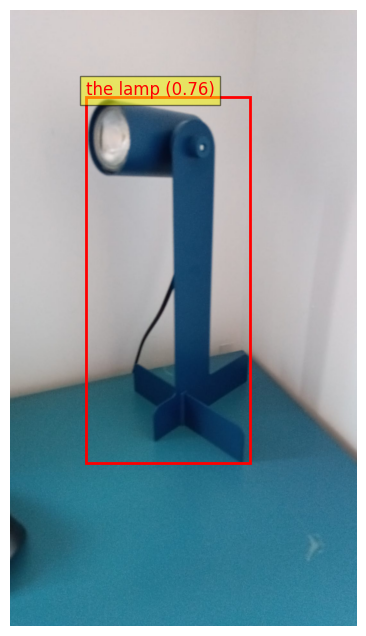

In [172]:
# 3) Visualizar (opcional) la imagen con bounding boxes
draw_boxes_and_labels(image_pil, results)



In [173]:
# 4) Segmentar con SAM cada caja
boxes = results['boxes']  # [N, 4]
masks = segment_with_sam(image_pil, boxes)



In [174]:
# 5) Guardar objetos segmentados individualmente
for i, (mask, label, score) in enumerate(zip(masks, results['labels'], results['scores'])):
    segmented_image = mask_to_transparent_image(image_pil, mask)
    x0, y0, x1, y1 = boxes[i].tolist()
    x0, y0, x1, y1 = map(int, [x0, y0, x1, y1])
    cropped_segmented = segmented_image.crop((x0, y0, x1, y1))

    filename = f"output/object_{i}_label_{label}_score_{score:.2f}.png"
    cropped_segmented.save(filename)
    print(f"Guardado: {filename}")



Guardado: outputs/object_0_label_the lamp_score_0.76.png


In [175]:
# 6) Identificar el objeto con mayor score y buscarlo en Internet
scores = results['scores']
if len(scores) == 0:
    print("No se detectó ningún objeto, no se realizará la búsqueda.")

max_score_idx = torch.argmax(scores).item()
best_label = results['labels'][max_score_idx]
best_score = scores[max_score_idx]

print(f"\nObjeto con mayor score: {best_label} (score={best_score:.2f})")




Objeto con mayor score: the lamp (score=0.76)


In [187]:
# 7) Buscar producto similar en Internet (Google Shopping vía SerpAPI)
search_similar_product_online("output/object_0_label_the lamp_score_0.76.png")


Buscando producto similar con Google Lens para la imagen: outputs/object_0_label_the lamp_score_0.76.png

Imagen subida con éxito a Imgur: https://i.imgur.com/w95fNgu.png
{'search_metadata': {'id': '67a102a45a9ed719c572c135', 'status': 'Success', 'json_endpoint': 'https://serpapi.com/searches/d462ff2ecd2ad3b9/67a102a45a9ed719c572c135.json', 'created_at': '2025-02-03 17:53:40 UTC', 'processed_at': '2025-02-03 17:53:40 UTC', 'google_lens_url': 'https://lens.google.com/uploadbyurl?url=https%3A%2F%2Fi.imgur.com%2Fw95fNgu.png&hl=en', 'raw_html_file': 'https://serpapi.com/searches/d462ff2ecd2ad3b9/67a102a45a9ed719c572c135.html', 'total_time_taken': 2.34}, 'search_parameters': {'engine': 'google_lens', 'url': 'https://i.imgur.com/w95fNgu.png', 'hl': 'en'}, 'visual_matches': [{'position': 1, 'title': 'FLOTTILJ desk lamp, dark blue - IKEA', 'link': 'https://www.ikea.com/us/en/p/flottilj-desk-lamp-dark-blue-40549771/', 'source': 'IKEA', 'source_icon': 'https://serpapi.com/searches/67a102a45a9ed